# Experiment: SML2010 Dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge,RidgeCV
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
from sklearn.utils import resample
import seaborn as sns

import torch
from torch.utils.data import Dataset,DataLoader
from torch import optim
import torch.nn as nn
import torch.nn.utils.prune as prune
import torch.nn.functional as F

df1=pd.read_csv('SML2010data-1.txt',sep = ' ')
df2=pd.read_csv('SML2010data-2.txt',sep = ' ')
tt=len(df1)
df=pd.concat([df1,df2],ignore_index=True)
x=df.iloc[:,4:]
y=df.iloc[:,3]

x=preprocessing.StandardScaler().fit(x).transform(x) #normalize
x=pd.DataFrame(x)
y=pd.DataFrame(y)
data=pd.concat([y,x],axis=1)
train=data[:tt]
test=data[tt:]
train_y = train.iloc[:,0]
train_x = train.iloc[:,1:]
test_y = test.iloc[:,0]
test_x = test.iloc[:,1:]

train_x.reset_index(drop=True, inplace=True) 
test_x.reset_index(drop=True, inplace=True) 
train_y.reset_index(drop=True, inplace=True) 
test_y.reset_index(drop=True, inplace=True) 

train_x

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,-3.449877,0.437610,0.509020,-0.343387,-0.256866,2.051876,1.671099,-0.207134,0.946759,0.099394,-0.199930,-0.041275,2.562800,1.685780,0.0,0.0,0.0,0.022328,-0.360980,-0.986859
1,-1.895536,0.586421,0.444629,-0.341419,-0.277320,2.054847,1.673094,-0.207134,0.946270,0.234846,-0.147298,-0.119228,2.562800,1.695987,0.0,0.0,0.0,0.092274,-0.402951,-0.986859
2,0.435975,0.562520,0.385491,-0.362862,-0.279562,2.042492,1.672977,-0.207134,0.944447,0.479461,-0.031168,-0.167174,2.561505,1.709373,0.0,0.0,0.0,0.194638,-0.430783,-0.986859
3,0.664555,0.527811,0.307411,-0.362308,-0.294990,2.045502,1.666967,-0.207134,0.944168,0.427707,0.148678,-0.168096,2.560206,1.708688,0.0,0.0,0.0,0.296721,-0.460984,-0.986859
4,1.121714,0.488312,0.267503,-0.362349,-0.298619,2.044116,1.659690,-0.207134,0.943606,0.863041,0.458431,-0.186965,2.560023,1.698145,0.0,0.0,0.0,0.401582,-0.575697,-0.986859
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2759,-0.478343,-0.705649,-0.720853,-0.149404,-0.344494,-0.682504,-0.690077,-0.207134,0.188877,-1.005128,-0.582892,-0.582018,-0.673330,-0.754226,0.0,0.0,0.0,-0.327053,-0.292805,-0.484013
2760,-0.676453,-0.710834,-0.684212,-0.148669,-0.340637,-0.673003,-0.540303,-0.207134,0.913128,-1.066147,-0.564479,-0.465468,-0.655586,-0.730905,0.0,0.0,0.0,-0.377628,-0.237932,-0.484013
2761,-0.706922,-0.710350,-0.659978,-0.146452,-0.336141,-0.367254,-0.448215,-0.207134,0.915371,-0.812267,-0.446350,0.113154,-0.559822,-0.657358,0.0,0.0,0.0,-0.410442,-0.236348,-0.484013
2762,-0.706922,-0.662065,-0.670978,-0.149778,-0.329704,-0.310925,-0.443583,-0.207134,0.920626,-0.821530,-0.314341,1.061254,-0.432217,-0.528944,0.0,0.0,0.0,-0.416043,-0.252537,-0.484013


In [2]:
nntrain_x = torch.from_numpy(train_x.to_numpy()).float()
nntrain_y = torch.squeeze(torch.from_numpy(train_y.to_numpy()).float()) 
nntest_x= torch.from_numpy(test_x.to_numpy()).float()
nntest_y = torch.squeeze(torch.from_numpy(test_y.to_numpy()).float())

class mydataset(Dataset):
    def __init__(self, x, y):
        self._x = x
        self._y = y
        self._len = len(x)

    def __getitem__(self, item): 
        return self._x[item], self._y[item]

    def __len__(self):
        return self._len

## 1. DNN

In [3]:
train_loader = DataLoader(mydataset(nntrain_x, nntrain_y),batch_size=128, shuffle=True)
test_loader = DataLoader(mydataset(nntest_x, nntest_y),batch_size=128, shuffle=False)

class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.fc1 = nn.Linear(20, 100)
        self.fc2 = nn.Linear(100, 50)
        self.fc3 = nn.Linear(50, 1)
    def forward(self,x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

#initialize
def init_weights(m):
    if type(m) == nn.Conv2d:
        torch.nn.init.normal_(m.weight,mean=0,std=0.5)
    if type(m) == nn.Linear:
        torch.nn.init.uniform_(m.weight,a=-0.1,b=0.1)
        m.bias.data.fill_(0)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = Net()
net = net.to(device)
torch.manual_seed(0)
net.apply(init_weights)
print(net)
criterion=nn.MSELoss() 
#optimizer=optim.SGD(net.parameters(),lr=1e-3,momentum=0.9,weight_decay=1e-2) #optim.Adam(...)
optimizer=optim.SGD([{'params': net.parameters(), 'initial_lr': 1e-3}],lr=1e-3,momentum=0.9,weight_decay=1e-2) #optim.Adam(...)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=100,gamma=0.5,last_epoch=200) 
dnn_trainloss=[]
dnn_testloss=[]
t0=time.time()
for epoch in range(500): 
    for x, y in train_loader: #for batch, (x, y) in enumerate(train_loader): 
        x, y = x.to(device), y.to(device)
        # Compute prediction error
        y_pred = net(x)
        y_pred = torch.squeeze(y_pred)
        train_loss = criterion(y_pred, y)
        # Backpropagation
        optimizer.zero_grad() 
        train_loss.backward()
        optimizer.step()
    scheduler.step()
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        y_test_pred = net(x)
        y_test_pred = torch.squeeze(y_test_pred)
    
        test_loss = criterion(y_test_pred,y)
    
    if epoch>50 and float(test_loss)>max(dnn_testloss[-50:-1]):
        break
    
    if epoch % 10 == 0:        
        print(f'''epoch {epoch}
            Train set - loss: {train_loss}
            Test  set - loss: {test_loss}
            ''')
    
    dnn_trainloss.append(float(train_loss))
    dnn_testloss.append(float(test_loss))
            
dnn_fit = time.time() - t0
print("DNN complexity and model fitted in %.3f s" % dnn_fit)

Net(
  (fc1): Linear(in_features=20, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=1, bias=True)
)
epoch 0
            Train set - loss: 11.075249671936035
            Test  set - loss: 25.468408584594727
            
epoch 10
            Train set - loss: 0.8052574992179871
            Test  set - loss: 1.6428942680358887
            
epoch 20
            Train set - loss: 0.32151055335998535
            Test  set - loss: 1.506882667541504
            
epoch 30
            Train set - loss: 0.3234308362007141
            Test  set - loss: 1.1510546207427979
            
epoch 40
            Train set - loss: 0.27940621972084045
            Test  set - loss: 0.9809380173683167
            
epoch 50
            Train set - loss: 0.19901947677135468
            Test  set - loss: 0.8277550339698792
            
epoch 60
            Train set - loss: 0.16888441145420074
            Test  set - loss: 0.

## 2. Resnet

In [4]:
train_loader = DataLoader(mydataset(nntrain_x, nntrain_y),batch_size=128, shuffle=True)
test_loader = DataLoader(mydataset(nntest_x, nntest_y),batch_size=128, shuffle=False)

class ResidualBlock(nn.Module):
    def __init__(self,infeatures,outfeatures):
        super(ResidualBlock,self).__init__()
        self.infeatures = infeatures
        self.outfeatures = outfeatures
        self.fc1 = nn.Linear(infeatures,outfeatures)
        self.fc2 = nn.Linear(infeatures,outfeatures)
    
    def forward(self, x):
        y = self.fc1(x)
        y= F.relu(y)
        x = self.fc2(x)
        return F.relu(x+y)


class ResNet(nn.Module): 
    def __init__(self):
        super(ResNet, self).__init__()
        self.rblock1 = ResidualBlock(20,100)
        self.rblock2 = ResidualBlock(100,50)
        self.fc3 = nn.Linear(50,1)
    
 
    def forward(self, x):
        x = self.rblock1(x)
        x = self.rblock2(x)
        return self.fc3(x)
#initialize
def init_weights(m):
    if type(m) == nn.Conv2d:
        torch.nn.init.normal_(m.weight,mean=0,std=0.5)
    if type(m) == nn.Linear:
        torch.nn.init.uniform_(m.weight,a=-0.1,b=0.1)
        m.bias.data.fill_(0)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = ResNet()
net = net.to(device)
torch.manual_seed(0)
net.apply(init_weights)
print(net)
criterion=nn.MSELoss() 
#optimizer=optim.SGD(net.parameters(),lr=1e-4,momentum=0.9,weight_decay=1e-2) #optim.Adam(...)
optimizer=optim.SGD([{'params': net.parameters(), 'initial_lr': 5e-4}],lr=5e-4,momentum=0.9,weight_decay=1e-2) #optim.Adam(...)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=100,gamma=0.5,last_epoch=200) 
res_trainloss=[]
res_testloss=[]
t0=time.time()
for epoch in range(500):
    for x, y in train_loader: #for batch, (x, y) in enumerate(train_loader): 
        x, y = x.to(device), y.to(device)
        # Compute prediction error
        y_pred = net(x)
        y_pred = torch.squeeze(y_pred)
        train_loss = criterion(y_pred, y)
        # Backpropagation
        optimizer.zero_grad() 
        train_loss.backward()
        optimizer.step()
    scheduler.step()
    
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        y_test_pred = net(x)
        y_test_pred = torch.squeeze(y_test_pred)
    
        test_loss = criterion(y_test_pred,y)
    
    if epoch>50 and float(test_loss)>max(res_testloss[-50:-1]):
        break
    
    if epoch % 10 == 0:        
        print(f'''epoch {epoch}
            Train set - loss: {train_loss}
            Test  set - loss: {test_loss}
            ''')
    
    res_trainloss.append(float(train_loss))
    res_testloss.append(float(test_loss))
            
dnn_fit = time.time() - t0
print("ResNet complexity and model fitted in %.3f s" % dnn_fit)

ResNet(
  (rblock1): ResidualBlock(
    (fc1): Linear(in_features=20, out_features=100, bias=True)
    (fc2): Linear(in_features=20, out_features=100, bias=True)
  )
  (rblock2): ResidualBlock(
    (fc1): Linear(in_features=100, out_features=50, bias=True)
    (fc2): Linear(in_features=100, out_features=50, bias=True)
  )
  (fc3): Linear(in_features=50, out_features=1, bias=True)
)
epoch 0
            Train set - loss: 17.650531768798828
            Test  set - loss: 35.264583587646484
            
epoch 10
            Train set - loss: 0.6027238965034485
            Test  set - loss: 1.6009107828140259
            
epoch 20
            Train set - loss: 0.2947774827480316
            Test  set - loss: 1.5785229206085205
            
epoch 30
            Train set - loss: 0.31202927231788635
            Test  set - loss: 1.614551067352295
            
epoch 40
            Train set - loss: 0.22160246968269348
            Test  set - loss: 1.3879830837249756
            
epoch 50
      

## Definition of RFF

In [22]:
def sample_1d(pdf, gamma):
    if pdf=='G':
        w=torch.randn(1)*gamma
        return w
    elif pdf=='L':
        w=torch.distributions.laplace.Laplace(torch.tensor([0.0]), torch.tensor([1.0])).sample()*gamma
        return w
    elif pdf=='C':
        w=torch.distributions.cauchy.Cauchy(torch.tensor([0.0]), torch.tensor([1.0])).sample()*gamma
        return w
    
def sample(pdf, gamma, d):
    return torch.tensor([sample_1d(pdf, gamma) for _ in range(d)])

class RandomFourierFeature:
    """Random Fourier Feature
    Parameters
    ----------
    d : int
        Input space dimension
    D : int
        Feature space dimension
    W : shape (D,d)
    b : shape (D)
    kernel : char
        Kernel to use; 'G', 'L', or 'C'
    gamma : float
        pdf parameter
    """

    def __init__(self, d, D, W=None, b=None, kernel='G', gamma=1):

        self.d = d
        self.D = D
        self.gamma = gamma

        kernel = kernel.upper()
        if kernel not in ['G', 'L', 'C']:
            raise Exception('Invalid Kernel')
        self.kernel = kernel

        if W is None or b is None:
            self.create()
        else:
            self.__load(W, b)

    def __load(self, W, b):
        """Load from existing Arrays"""

        self.W = W.reshape([self.D, self.d])
        self.b = b
    

    def create(self):
        """Create a d->D fourier random feature"""

        self.b = torch.rand(self.D)*2*torch.pi
        self.W = sample(self.kernel, self.gamma, self.d*self.D).reshape(self.D,self.d)

    def transform(self, x):
        """Transform a vector using this feature
        Parameters
        ----------
        x : (shape=(n,d))
            to transform; must be single dimension vector
        Returns
        -------
        x : (shape=(n,D))
            Feature space transformation of x
        """
        #print(self.W.shape,self.b.reshape(-1,1).shape,x.shape)
        #print((self.W @ x.T).shape)
       
        result=torch.sqrt(torch.tensor([2.0/self.D])) * torch.cos( self.W @ x.T  + (self.b.reshape(-1,1) @ torch.ones(len(x)).reshape(1,-1))) 
        #print(result.T.shape)
        return result.T

## 3. multilayer learning

In [79]:
train_loader = DataLoader(mydataset(nntrain_x, nntrain_y),batch_size=128, shuffle=True)
test_loader = DataLoader(mydataset(nntest_x, nntest_y),batch_size=128, shuffle=False)

rff1=RandomFourierFeature(20,100,kernel='C',gamma=0.1)
rff2=RandomFourierFeature(50,50,kernel='G',gamma=0.5)

class KernelNet(nn.Module): 
    def __init__(self):
        super(KernelNet, self).__init__()
        self.fc1 = nn.Linear(100, 50)
        self.fc2 = nn.Linear(50, 1)
        
    def forward(self, x):
        x = rff1.transform(x)
        x=self.fc1(x)
        x = rff2.transform(x)
        return self.fc2(x)


#initialize
def init_weights(m):
    if type(m) == nn.Conv2d:
        torch.nn.init.normal_(m.weight,mean=0,std=0.5)
    if type(m) == nn.Linear:
        torch.nn.init.uniform_(m.weight,a=-0.5,b=0.5)
        m.bias.data.fill_(0)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = KernelNet()
net = net.to(device)
torch.manual_seed(1)
net.apply(init_weights)
print(net)
criterion=nn.MSELoss() 
#optimizer=optim.SGD(net.parameters(),lr=1e-4,momentum=0.9,weight_decay=1e-2) #optim.Adam(...)
optimizer=optim.SGD([{'params': net.parameters(), 'initial_lr': 1e-3}],lr=1e-3,momentum=0.9,weight_decay=1e-2) #optim.Adam(...)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=50,gamma=0.5,last_epoch=200) 
loss=[]
kernelnn_trainloss=[]
kernelnn_testloss=[]
t0 = time.time()
for epoch in range(500): 
    for x, y in train_loader: #for batch, (x, y) in enumerate(train_loader): 
        x, y = x.to(device), y.to(device)
        # Compute prediction error
        y_pred = net(x)
        y_pred = torch.squeeze(y_pred)
        train_loss = criterion(y_pred, y)
        loss.append(train_loss)
        # Backpropagation
        optimizer.zero_grad() 
        train_loss.backward()
        optimizer.step()
    #scheduler.step()
    
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        y_test_pred = net(x)
        y_test_pred = torch.squeeze(y_test_pred)

        test_loss = criterion(y_test_pred,y)
            
    if epoch>50 and float(test_loss)>max(kernelnn_testloss[-50:-1]):
        break
    
    
    if epoch % 10 == 0:         
        print(f'''epoch {epoch}
            Train set - loss: {train_loss}
            Test  set - loss: {test_loss}
            ''')
   
    kernelnn_trainloss.append(float(train_loss))
    kernelnn_testloss.append(float(test_loss))
        
    
dnn_fit = time.time() - t0
print("KernelNet complexity and model fitted in %.3f s" % dnn_fit)

KernelNet(
  (fc1): Linear(in_features=100, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=1, bias=True)
)
epoch 0
            Train set - loss: 141.9015350341797
            Test  set - loss: 178.1690216064453
            
epoch 10
            Train set - loss: 1.8255542516708374
            Test  set - loss: 2.064455032348633
            
epoch 20
            Train set - loss: 0.7372742891311646
            Test  set - loss: 1.388684868812561
            
epoch 30
            Train set - loss: 0.48027846217155457
            Test  set - loss: 0.9355813264846802
            
epoch 40
            Train set - loss: 0.4415716826915741
            Test  set - loss: 0.7388301491737366
            
epoch 50
            Train set - loss: 0.4751010835170746
            Test  set - loss: 0.6712427139282227
            
epoch 60
            Train set - loss: 0.49816206097602844
            Test  set - loss: 0.5470230579376221
            
epoch 70
            Train set

## 4. Residual multilayer learning

In [66]:
train_loader = DataLoader(mydataset(nntrain_x, nntrain_y),batch_size=128, shuffle=True)
test_loader = DataLoader(mydataset(nntest_x, nntest_y),batch_size=128, shuffle=False)

rff0=RandomFourierFeature(20,100,kernel='C',gamma=0.1)
rff1=RandomFourierFeature(50,50,kernel='G',gamma=0.5)

class ResidualBlock(nn.Module):
    def __init__(self,infeatures,outfeatures,rff):
        super(ResidualBlock,self).__init__()
        self.infeatures = infeatures
        self.outfeatures = outfeatures
        self.rff=rff
        
        self.fc1 = nn.Linear(infeatures,outfeatures)
        self.fc2 = nn.Linear(outfeatures,outfeatures)
    
    def forward(self, x):
        rff=self.rff
        x = self.fc1(x)
        y = rff.transform(x)
        y = self.fc2(y)
        return x+y

class ResKernelNet(nn.Module): 
    def __init__(self):
        super(ResKernelNet, self).__init__()
        self.rblock1 = ResidualBlock(100,50,rff1)
        self.fc2 =nn.Linear(50,1)
 
    def forward(self, x):
        x = rff0.transform(x)
        x = self.rblock1(x)
        return self.fc2(x)

#initialize
def init_weights(m):
    if type(m) == nn.Conv2d:
        torch.nn.init.normal_(m.weight,mean=0,std=0.5)
    if type(m) == nn.Linear:
        torch.nn.init.uniform_(m.weight,a=-0.5,b=0.5)
        m.bias.data.fill_(0)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = ResKernelNet()
net = net.to(device)
torch.manual_seed(1)
#net.apply(init_weights)
print(net)
criterion=nn.MSELoss() 
#optimizer=optim.SGD(net.parameters(),lr=1e-4,momentum=0.9,weight_decay=1e-2) #optim.Adam(...)
optimizer=optim.SGD([{'params': net.parameters(), 'initial_lr': 5e-4}],lr=5e-4,momentum=0.9,weight_decay=1e-2) #optim.Adam(...)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=50,gamma=0.5,last_epoch=200) 


loss=[]
reskernel_trainloss=[]
reskernel_testloss=[]
t0 = time.time()
for epoch in range(500): 
    for x, y in train_loader: #for batch, (x, y) in enumerate(train_loader): 
        x, y = x.to(device), y.to(device)
        # Compute prediction error
        y_pred = net(x)
        y_pred = torch.squeeze(y_pred)
        train_loss = criterion(y_pred, y)
        loss.append(train_loss)
        # Backpropagation
        optimizer.zero_grad() 
        train_loss.backward()
        optimizer.step()
    scheduler.step()
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        y_test_pred = net(x)
        y_test_pred = torch.squeeze(y_test_pred)

        test_loss = criterion(y_test_pred,y)
            
    if epoch>50 and float(test_loss)>max(reskernel_testloss[-50:-1]):
        break
    
    
    if epoch % 10 == 0:         
        print(f'''epoch {epoch}
            Train set - loss: {train_loss}
            Test  set - loss: {test_loss}
            ''')
    reskernel_trainloss.append(float(train_loss))
    reskernel_testloss.append(float(test_loss))
        
    
dnn_fit = time.time() - t0
print("Residual KernelNet complexity and model fitted in %.3f s" % dnn_fit)

ResKernelNet(
  (rblock1): ResidualBlock(
    (fc1): Linear(in_features=100, out_features=50, bias=True)
    (fc2): Linear(in_features=50, out_features=50, bias=True)
  )
  (fc2): Linear(in_features=50, out_features=1, bias=True)
)
epoch 0
            Train set - loss: 42.0438346862793
            Test  set - loss: 24.062646865844727
            
epoch 10
            Train set - loss: 1.1221270561218262
            Test  set - loss: 1.4797708988189697
            
epoch 20
            Train set - loss: 1.737665057182312
            Test  set - loss: 0.9671225547790527
            
epoch 30
            Train set - loss: 1.537799596786499
            Test  set - loss: 0.6952484846115112
            
epoch 40
            Train set - loss: 0.6665270328521729
            Test  set - loss: 0.5110800266265869
            
epoch 50
            Train set - loss: 1.2883588075637817
            Test  set - loss: 0.5648188591003418
            
epoch 60
            Train set - loss: 0.771220386028

comparison

In [5]:
def plot_choose(fig,start,data):
    fig.plot(np.arange(start,len(data)),data[start:])

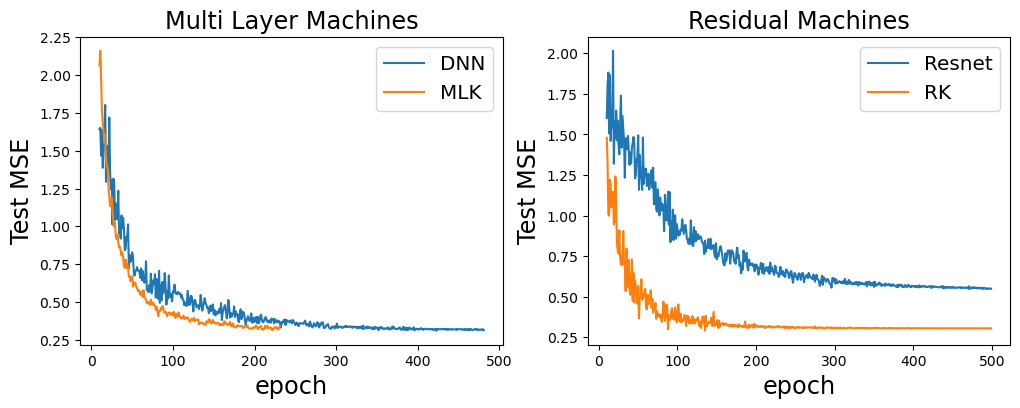

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
plot_choose(ax[0],10,dnn_testloss)
plot_choose(ax[0],10,kernelnn_testloss)
ax[0].legend(["DNN","MLK"],fontsize="x-large")
ax[0].set_xlabel("epoch",fontsize="xx-large")
ax[0].set_ylabel("Test MSE",fontsize="xx-large")
ax[0].set_title("Multi Layer Machines",fontsize="xx-large")

plot_choose(ax[1],10,res_testloss)
plot_choose(ax[1],10,reskernel_testloss)
ax[1].legend(["Resnet","RK"],fontsize="x-large")
ax[1].set_xlabel("epoch",fontsize="xx-large")
ax[1].set_ylabel("Test MSE",fontsize="xx-large")
ax[1].set_title("Residual Machines",fontsize="xx-large")
plt.show()

In [147]:
def sample_1d(pdf, gamma):
    if pdf=='G':
        w=np.random.randn(1)*gamma
        return w
    elif pdf=='L':
        w=np.random.laplace(1)*gamma
        return w
    elif pdf=='C':
        w=np.random.standard_cauchy(1)*gamma
        return w
    

def sample(pdf, gamma, d):
    return [sample_1d(pdf, gamma) for _ in range(d)]


class RandomFourierFeature:
    """Random Fourier Feature
    Parameters
    ----------
    d : int
        Input space dimension
    D : int
        Feature space dimension
    W : np.array
        shape (D,d)
    b : np.array
        shape (D)
    kernel : char
        Kernel to use; 'G', 'L', or 'C'
    gamma : float
        pdf parameter
    """

    def __init__(self, d, D, W=None, b=None, kernel='G', gamma=1):

        self.d = d
        self.D = D
        self.gamma = gamma

        kernel = kernel.upper()
        if kernel not in ['G', 'L', 'C']:
            raise Exception('Invalid Kernel')
        self.kernel = kernel

        if W is None or b is None:
            self.create()
        else:
            self.__load(W, b)

    def __load(self, W, b):
        """Load from existing Arrays"""

        self.W = W.reshape([self.D, self.d])
        self.b = b
    

    def create(self):
        """Create a d->D fourier random feature"""

        self.b = np.random.uniform(0, 2 * np.pi, self.D)
        self.W = np.reshape(
            np.array([
                sample(self.kernel, self.gamma, self.d)
                for _ in range(self.D)], dtype=np.float32),
            (self.D, self.d))

    def transform(self, x):
        """Transform a vector using this feature
        Parameters
        ----------
        x : np.array (shape=(n,d))
            Array to transform; must be single dimension vector
        Returns
        -------
        x : np.array (shape=(n,D))
            Feature space transformation of x
        """
        x=pd.DataFrame(x)
        result=np.array([
            np.sqrt(2 / self.D) * np.cos(np.dot(self.W, x.iloc[i]) + self.b) for i in range(len(x))]
            )            
        return result
    
model =Ridge(alpha=0.001)
score=[]
trainmse=[]
testmse=[]
gaset=np.logspace(-2,0,5)
for ga in gaset:
    rff=RandomFourierFeature(20,1000,kernel='G',gamma=ga)
    total_x=pd.concat([train_x,test_x])
    feature=rff.transform(total_x)
    train_xtransformed=feature[:len(train_x)]
    test_xtransformed=feature[len(train_x):]
    model.fit(train_xtransformed, train_y)
    y_pretest=model.predict(test_xtransformed)
    y_pretrain=model.predict(train_xtransformed)
    score.append(cross_val_score(model,train_xtransformed,train_y,cv=5).mean())   ##cross-validation
    trainmse.append(mean_squared_error(y_pretrain,train_y))
    testmse.append(mean_squared_error(y_pretest,test_y))
ind=score.index(max(score))
print("cv-score,index,gamma,trainmse,testmse",max(score),ind,gaset[ind],trainmse[ind],testmse[ind])

cv-score,index,gamma,trainmse,testmse 0.8038558805971758 1 0.03162277660168379 0.2994849949002857 1.218457578141555
